In [1]:
import numpy as np
from scipy.stats import ks_2samp, ks_1samp, kstest
import json
import pandas as pd
import matplotlib.pyplot as plt
from random import choices
import os
from scipy.stats import bernoulli
from scipy.stats import zipf

In [2]:
import re
def match_regex_array(files, regex):
    matches = [re.findall(regex, f) for f in files]
    matches = ["./sim_results/" + m[0] for m in matches if len(m) > 0 ]
    return matches

In [3]:
# Apply KS-test using a large number of samples from the reference distribution 
# and a small sample from a "test" (in this case, the Network-Aware) distribution multiple times
# Each test sample represents a bot consuming contents from NA-distribution
# Function returns the mean of the p_values for all KS-tests performed for each bot
# and the proportion of null hypothesis rejection, i.e., samples were not generated from the same distribution
def covertness_kstest(ref_dist, test_dist, population, ref_dist_size=10**6, test_dist_size=10**3, N_bots = 100, rounds=30):
    p_values_mean_rounds = []
    rejection_proportions_rounds = []
    ref_dist_large_samples = choices(population, ref_dist, k=ref_dist_size)
    for i in range(rounds):
        p_values = []        
        null_hypothesis_rejections = 0
        for j in range(N_bots):
            test_dist_samples = choices(population, test_dist, k=test_dist_size) # bot "watches" amount of contents
            ks = ks_2samp(ref_dist_large_samples, test_dist_samples)
            p_values.append(ks.pvalue)
            if (ks.pvalue < 0.05):
                null_hypothesis_rejections += 1
        p_values_mean = np.mean(p_values)
        null_hypothesis_rejections /= N_bots

        p_values_mean_rounds.append(p_values_mean)
        rejection_proportions_rounds.append(np.mean(null_hypothesis_rejections))
    return p_values_mean_rounds, rejection_proportions_rounds

In [4]:
# aggregated mode
def covertness_kstest_aggregate(baseline_samples, test_dist, population, test_dist_size=10**3, N_bots = 100, rounds=30):
    p_values_rounds = []
    null_hypothesis_rejections = 0
    for i in range(rounds):
        # print("round ", i, end=' ')
        test_agg_samples = []
        for j in range(N_bots):
            test_dist_samples = choices(population, test_dist, k=test_dist_size) # bot "watches" amount of contents
            test_agg_samples += test_dist_samples
        ks = ks_2samp(baseline_samples, test_agg_samples)
        if (ks.pvalue < 0.05):
            null_hypothesis_rejections += 1
        p_values_rounds.append(ks.pvalue)        
    return p_values_rounds, null_hypothesis_rejections/rounds

In [10]:
# aggregated mode simplified
def covertness_kstest_aggregate(baseline_samples, test_dist, population, test_dist_size=10**3, rounds=30):
    p_values_rounds = []
    null_hypothesis_rejections = 0
    for i in range(rounds):
        # print("round ", i, end=' ')
        test_agg_samples = choices(population, test_dist, k=test_dist_size)
        ks = ks_2samp(baseline_samples, test_agg_samples)
        if (ks.pvalue < 0.05):
            null_hypothesis_rejections += 1
        p_values_rounds.append(ks.pvalue)        
    return p_values_rounds, null_hypothesis_rejections/rounds


In [11]:
# aggregated mode RANDOM CONTENTS PER BOT
# def covertness_kstest_aggregate_random_contents_per_bot(baseline_samples, test_dist, population, contents_per_user_population, contents_per_user_dist, N_bots = 100, rounds=30):
#     p_values_rounds = []
#     null_hypothesis_rejections = 0
#     for i in range(rounds):
#         # print("round ", i, end=' ')
#         test_agg_samples = []
#         for j in range(N_bots):
#             test_dist_size = choices(contents_per_user_population, contents_per_user_dist, k=1)[0]
#             test_dist_samples = choices(population, test_dist, k=test_dist_size) # bot "watches" amount of contents
#             test_agg_samples += test_dist_samples
#         # print(len(test_agg_samples), end=",")
#         ks = ks_2samp(baseline_samples, test_agg_samples)
#         if (ks.pvalue < 0.05):
#             null_hypothesis_rejections += 1
#         p_values_rounds.append(ks.pvalue)        
#     return p_values_rounds, null_hypothesis_rejections/rounds

In [12]:
# random walker

def covertness_kstest_random_walker(baseline_samples, p0, R, N, alpha, N_bots, contents_per_bot, rounds, R_top=False):
    R = np.array(R)
    p0 = np.array(p0)
    population = np.arange(len(p0))
    null_hypothesis_rejections = 0
    for i in range(rounds):        
        consumed = []
        for j in range(N_bots):            
            first_content = choices(population, p0, k=1)[0]            
            consumed.append(first_content)
            current_content = first_content
            for k in range(contents_per_bot):
                follow_recommendation = bernoulli.rvs(p=alpha, size=1)[0]
                if follow_recommendation:
                    ri = R[current_content, :]
                    ri_idx = np.where(ri > 0)[0] # index of > 0 elements
                    content = choices(population=ri_idx, weights=ri[ri_idx]/ri[ri_idx].sum(), k=1)[0]
                else:
                    content = choices(population, p0, k=1)[0]
                current_content = content
                consumed.append(current_content)
        ks = ks_2samp(baseline_samples, consumed)
        if (ks.pvalue < 0.05):
            null_hypothesis_rejections += 1
    return null_hypothesis_rejections/rounds
                

In [8]:
from os.path import exists

def ci_proportion(p_hat, n):
    std_hat = np.sqrt((p_hat*(1-p_hat))/n)
    lower = p_hat - 1.96*std_hat
    upper = p_hat + 1.96*std_hat
    return lower, p_hat, upper

def save_confidence_intervals(cis, test_dist_sizes, rounds, bots):
    filename = "confidence_interval_test_size" + "tds" + str(test_dist_sizes[0]) + \
        "-" + str(test_dist_sizes[-1]) + "_rounds_" + str(rounds) + \
        "_bots_" + str(bots) + ".txt"
    if (not exists(filename)):
        lowers = np.array([cis[i][0] for i in range(len(cis))])
        means = np.array([cis[i][1] for i in range(len(cis))])
        uppers = np.array([cis[i][2] for i in range(len(cis))])
        f = open(filename, "w")
        n_intervals = len(means)
        for i in range(n_intervals):            
            f.write(str(lowers[i]) + "," + str(means[i]) + "," + \
                    str(uppers[i]) + "\n")
        f.close()
    else:
        print("{} file already exists".format(filename))
    

In [9]:
def plot_confidence_intervals(x, filename, fig, ax, label, color):
    try:
        f = open(filename, "r")
        cis = np.array([np.array(line.rstrip().split(",")).astype(float) for line in f.readlines()])        
        lowers = np.around(cis[:, 0], decimals=2)
        means = np.around(cis[:, 1], decimals=2)
        uppers = np.around(cis[:, 2], decimals=2)
        print(uppers)
        if not fig or not ax:
            fig, ax = plt.subplots()
        ax.plot(x, means, label=label, color=color)
        ax.fill_between(x, lowers, uppers, color=color, alpha=.1)
#         plt.xlabel("Perturbed Distribution Sample")
        plt.xlabel("Contents per bot")
        plt.ylabel("Proportion of null hypothesis rejections")
        # plt.savefig("proportions_nbots30.png")
        # plt.show()
    except Exception as e:
        print(e)

In [17]:
def kl(p,q,alpha=0):
	'''
	Returns the KL distance between the two distributions p1 and p2. In case the parameter "alpha" is >0, it returns a smoothed version of the KL distance [Steck18].
	If the KL distance diverges (becomes inf) then the function returns the value np.nan

	[Steck18] Harald Steck. 2018. Calibrated recommendations. In ACM RecSys. ACM, 154–162
	'''
	d = [np.nan]*len(p) # initialize the list with the kl distance per item in the distribution
	q_smooth = [(1-alpha)*q[i]+ alpha*p[i]  for i in range(len(p))]
	for i in range(len(p)):
		if p[i]==0:
			d[i] = [0]
		else:
			if q_smooth[i]==0:
				d[i] = np.nan # the KL metrics diverges (becomes inf)
			else:
				d[i] = p[i]*np.log(p[i]/q_smooth[i])
	if alpha==0:
		return np.sum(d)
	else:
		return np.sum(d) / np.log(1/alpha)
    
def p_fairness(pNA,pBS,metric):
	'''
	This method receives two lists, representing content demand distributions (p[i] is the fraction of demand for the i^{th} content), 
	and a string that denotes which fairness measure will be used, 
	and returns a value for the fairness measure (or, "difference") of the given lists
	Input:
		pNA: a list of the first content demand distribution; this correspongs to the network-aware (NA) RS case
		pBS: a list of the second content demand distribution (should be of the same length with pNA); this correspongs to the baseline (BS) RS case
		metric: a string to denote which fairness measure to be used; it can take values {'avg', 'sum', 'max', 'kl', 'kl-smooth'}

	'''
	if metric=='avg':
		f = 0.5 * np.sum([np.abs(pNA[i]-pBS[i]) for i in range(len(pNA))])
	elif metric=='sum':
		f = np.sum([np.abs(pNA[i]-pBS[i]) for i in range(len(pNA))])
	elif metric=='max':
		r = [np.abs(pNA[i]-pBS[i]) for i in range(len(pNA))]
		f = np.max([np.abs(pNA[i]-pBS[i]) for i in range(len(pNA))])
	elif metric=='kl':
		f = kl(pNA,pBS)
	elif metric=='kl-inv':
		f = kl(pBS,pNA)
	elif metric=='kl-smooth':
		f = kl(pNA,pBS,alpha=0.01)
	elif metric=='kl-smooth-inv':
		f = kl(pBS,pNA,alpha=0.01)
	else:
		raise ValueError('The given metric "{}" is not within the available options'.format(metric))
	return f

In [ ]:
def rejections_in_function_of_sample_size_and_fairness(file, n_bots = 10, n_rounds=100, fairness_metric='avg'):
    # x test sample sizes VARIES
    # y fairness CONSTANT
    # z rejections VARIES
#     print(file)
    alpha = float(file.split('/sim_results_')[1].split('_')[2][1:])
    N = int(file.split('/sim_results_')[1].split('_')[3][1:])
    data = json.load(open(file))
    ref_dist_size=10**3
    ref_dist = data['pi_bs']
    catalog_size = len(data['p0'])
    population = np.arange(catalog_size)
    ref_dist_samples = choices(population, ref_dist, k=ref_dist_size)
    proportions = []
    test_sample_sizes = np.linspace(10, 100, 10).astype(int)
    for tds in test_sample_sizes:
#         print(tds, end=',')
        contents_per_bot = tds
        proportion = covertness_kstest_random_walker(ref_dist_samples, \
                                                      data['p0'], \
                                                   data['R_NA'], \
                                                   N, alpha, n_bots,\
                                                   contents_per_bot,\
                                                   n_rounds)
        proportions.append(proportion)
    print(file, end=',')
    fairness = p_fairness(data['pi_final_NA'], data['pi_bs'], fairness_metric)
    print(fairness, end=' ')
    x = test_sample_sizes
    y = np.repeat(fairness, len(x))
    z = proportions
    return x, y, z

    

In [47]:
# TESTING ONE SCENARIO ONLY FOR NOW

path = "/home/mateus/NFR-master-old/Simulator/sim_results/"
data_lastfm = json.load(open(path + "sim_results_Ulastfm_pop0_a0.8_N2_C5_CPtop_Q0.5_L40.json"))
lastfm_size = len(data_lastfm['p0'])
data_movielens = json.load(open(path + "sim_results_Umovielens1k_pop1_a0.8_N10_C10_CPtop_Q0.9_L40.json"))
movielens_size = len(data_movielens['p0'])
population_movielens = np.arange(movielens_size)
population_lastfm = np.arange(lastfm_size)

In [48]:
baseline_samples = choices(population_movielens, data_movielens['pi_bs'], k=10**4)
na_samples = choices(population_movielens, data_movielens['pi_final_NA'], k=10**4)

In [49]:
print("Fairness: ", p_fairness(data_movielens['pi_final_NA'], data_movielens['pi_bs'], 'avg'))

Fairness:  0.4196712369067939


In [50]:
N = 10
alpha = 0.5
N_bots = 1
contents_per_bot = 100
p_rw = covertness_kstest_random_walker(baseline_samples, data_movielens['p0'], data_movielens['R_NA'], N, alpha, N_bots, contents_per_bot, 100, R_top=False)
p_rw


1.0

In [193]:
path = "/home/mateus/NFR-master/Simulator/sim_results/"
file = path + "sim_results_Ulastfm_pop0_a0.5_N2_C5_CPtop_Q0.5_L40.json"
# file = path + "sim_results_Ulastfm_pop0_a0.99_N2_C5_CPtop_Q0.5_L40.json"
x, y, z = rejections_in_function_of_sample_size_and_fairness(file)


/home/mateus/NFR-master/Simulator/sim_results/sim_results_Ulastfm_pop0_a0.5_N2_C5_CPtop_Q0.5_L40.json
0.35668726692764596


In [54]:
# print(x)
# print(y)
# print(z)

In [55]:
# Getting non-optimal simulation results
sim_results = os.listdir(path)
print(len(sim_results))
optm_max = match_regex_array(sim_results, r'.*Fmax.*')
optm_max = [f.split('/sim_results/')[1] for f in optm_max]
optm_tv = match_regex_array(sim_results, r'.*FTV.*')
optm_tv = [f.split('/sim_results/')[1] for f in optm_tv]
optm_kl = match_regex_array(sim_results, r'.*FKL.*')
optm_kl = [f.split('/sim_results/')[1] for f in optm_kl]
sim_results = [sm for sm in sim_results if not os.path.isdir(path + sm) and sm not in optm_max + optm_tv + optm_kl]
print(len(sim_results))


1137
893


In [ ]:
from random import choice, sample
# files_sample = sample(sim_results, k=50)
files_sample = sim_results
X = []
Y = []
Z = []
i = 0
for f in files_sample:
    print("i:", i, end=', ')
    i+=1
    try:
        x, y, z = rejections_in_function_of_sample_size_and_fairness(path+f)
        X.append(x)
        Y.append(y)
        Z.append(z)
    except Exception as e:
        print(e)
    

i: 0, /home/mateus/NFR-master-old/Simulator/sim_results/sim_results_Umovielens1k_pop0_a0.99_N5_C10_CPtop_Q1.0_cabaret_W1_D2.json
0.5394034979978959
i: 1, /home/mateus/NFR-master-old/Simulator/sim_results/sim_results_Umovielens1k_pop1_a0.5_N10_C5_CPtop_Q1.0_cabaret_W1_D2.json
0.009275413394348585
i: 2, /home/mateus/NFR-master-old/Simulator/sim_results/sim_results_Umovielens1k_pop0_a0.5_N10_C10_CPtop_Q0.9_L1.json
0.1347049727161427
i: 3, /home/mateus/NFR-master-old/Simulator/sim_results/sim_results_Ulastfm_pop0_a0.8_N5_C10_CPtop_Q0.5_L1.json
0.5968887586137496
i: 4, /home/mateus/NFR-master-old/Simulator/sim_results/sim_results_Umovielens1k_pop1_a0.8_N10_C10_CPtop_Q1.0_cabaret_W2_D1.json
0.12851884921725706
i: 5, /home/mateus/NFR-master-old/Simulator/sim_results/sim_results_Ulastfm_pop0_a0.99_N2_C20_CPtop_Q1.0_cabaret_W1_D2.json
0.5118242755638995
i: 6, /home/mateus/NFR-master-old/Simulator/sim_results/sim_results_Umovielens1k_pop1_a0.5_N5_C10_CPtop_Q0.9_L1.json
0.10914611536727868
i: 7, 

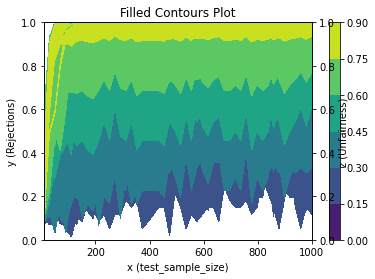

<Figure size 864x576 with 0 Axes>

In [205]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Z, Y)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x (test_sample_size)')
ax.set_ylabel('y (Rejections)')
ax.yaxis.tick_right()
ax2 = ax.twinx()
ax2.set_ylabel('z (Unfairness)')
plt.figure(figsize=(12,8))
plt.show()

In [178]:
x = np.arange(5)
y = np.arange(5, 10)
np.meshgrid(x, y)

[array([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]]),
 array([[5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6],
        [7, 7, 7, 7, 7],
        [8, 8, 8, 8, 8],
        [9, 9, 9, 9, 9]])]

In [63]:
# Confidence Interval
# def get_rejections_cis_filename(file, n_bots, n_rounds):
#     alpha = float(file.split('/sim_results_')[1].split('_')[2][1:])
#     N = int(file.split('/sim_results_')[1].split('_')[3][1:])
#     data = json.load(open(file))
#     test_sample_sizes = np.linspace(10, 50, 10).astype(int)
#     confidence_intervals = []
#     ref_dist_size=10**4
#     ref_dist = data['pi_bs']
#     ref_dist_samples = choices(population, ref_dist, k=ref_dist_size)
#     cis = []
#     cis = []
#     for tds in test_sample_sizes:
#         print(tds, end=',')
#         contents_per_bot = tds
#         proportion = covertness_kstest_random_walker(ref_dist_samples, \
#                                                       data['p0'], \
#                                                    data['R_NA'], \
#                                                    N, alpha, n_bots,\
#                                                    contents_per_bot,\
#                                                    n_rounds)
#         cis.append(np.array(ci_proportion(proportion, nrounds)))
#     return cis
# cis = get_rejections_cis_filename(file)


[save_confidence_intervals(cis, [10, 50], nrounds, nbots) for i in range(len(cis))]

10,10,14,18,23,27,32,36,41,45,50,20,10,14,18,23,27,32,36,41,45,50,30,10,14,18,23,27,32,36,41,45,50,

[0.78 0.87 0.9  0.99 0.97 1.01 1.   1.01 1.   1.  ]
[0.99 1.   1.01 1.01 1.   1.   1.   1.   1.   1.  ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


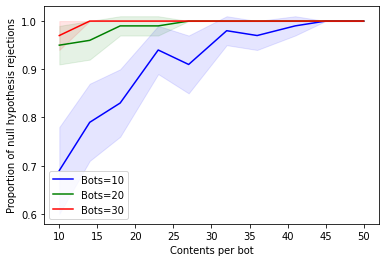

In [79]:
fig, ax = plt.subplots()
plot_confidence_intervals(test_dist_sizes, "confidence_interval_test_sizetds10-50_rounds_100_bots_10.txt", fig, ax, 'Bots=10', 'b')
plot_confidence_intervals(test_dist_sizes, "confidence_interval_test_sizetds10-50_rounds_100_bots_20.txt", fig, ax, 'Bots=20', 'g')
plot_confidence_intervals(test_dist_sizes, "confidence_interval_test_sizetds10-50_rounds_100_bots_30.txt", fig, ax, 'Bots=30', 'r')
plt.legend()
plt.savefig("proportions.png")

In [10]:
# rna = np.array(data_movielens['R_NA'])
# rows = rna.shape[0]
# means = []
# for i in range(rows):
#     ri = rna[i]
#     ri = ri[ri > 0]
#     means.append(len(ri))
# means

In [262]:
# test_dist_sizes = np.linspace(10, 50, 40).astype(int)
# proportions = []
# confidence_intervals = []
# ref_dist_size=10**3
# ref_dist = data_movielens['pi_bs']
# ref_dist_samples = choices(population_movielens, ref_dist, k=ref_dist_size)
# vcs = df['user id'].value_counts() 
# # unique_counts = np.asarray((unique, counts)).T
# contents_per_user_population, contents_per_user_dist = np.unique(vcs, return_counts=True)
# nrounds = 100
# # n_bots = [10, 20, 30]
# n_bots = np.linspace(10, 50, 40).astype(int)
# cis = []
# for nbots in n_bots:
#     print(nbots, end=',')
#     # cis = []
#     # for tds in test_dist_sizes:
#         # print(tds, end=',')
#     p_values, proportion = covertness_kstest_aggregate_random_contents_per_bot(\
#                                                ref_dist_samples, \
#                                                data_movielens['pi_final_NA'], \
#                                                population_movielens, \
#                                                contents_per_user_population//10,
#                                                contents_per_user_dist,
#                                                N_bots=nbots, rounds=nrounds)
#     proportions.append(proportion)
#     cis.append(np.array(ci_proportion(proportion, nrounds)))
# save_confidence_intervals(cis, [0, 700], nrounds, nbots)

10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,50,

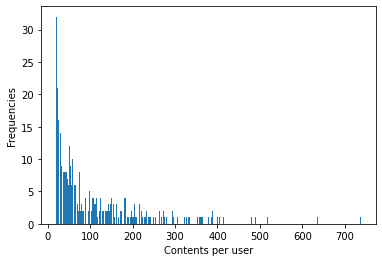

In [281]:
plt.bar(contents_per_user_population, contents_per_user_dist)
plt.xlabel("Contents per user")
plt.ylabel("Frequencies")
plt.savefig("contents_per_user_freq.png")

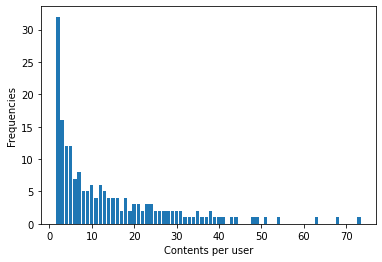

In [282]:
plt.bar(contents_per_user_population//10, contents_per_user_dist)
plt.xlabel("Contents per user")
plt.ylabel("Frequencies")
plt.savefig("contents_per_user_freq_div_10.png")

In [263]:
# save_confidence_intervals(cis, test_dist_sizes, nrounds, nbots)

[Errno 2] No such file or directory: 'confidence_interval_random_test_sizetds0-700_rounds_100_bots_50.txt'


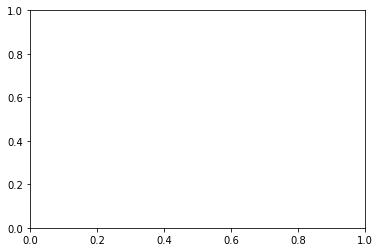

In [78]:
fig, ax = plt.subplots()
plot_confidence_intervals(n_bots, "confidence_interval_random_test_sizetds0-700_rounds_100_bots_50.txt", fig, ax, '', 'b')
plt.savefig("proportions_nbots.png")

In [23]:
# for the not aggregated case
# test_dist_sizes = np.linspace(10, 40, 4).astype(int)
# pvalues_mean_sample = []
# proportion_mean_sample = []
# confidence_intervals = []
# for tds in test_dist_sizes:
#     print(tds)
#     p_values_means, proportion_means = covertness_kstest(data_movielens['pi_bs'], data_movielens['pi_final_NA'], population_movielens, ref_dist_size=10**4, test_dist_size=tds, N_bots=50, rounds=30)
#     pvalues_mean_sample.append(p_values_means)
#     proportion_mean_sample.append(proportion_means)